In [1]:
import os,sys
import numpy as np
import time

import torch
from torch import nn
from torch.utils.data import DataLoader

from dataset import CosDataset, train_tfm, test_tfm
from model import CNN_cosmo

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## model
mode = "cosmo"
## dataset
rng_seed = 114514
batch_size = 32
training_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1
## training
n_epoch = 1000
lr = 0.002

net_cos = CNN_cosmo("cosmo")
net_all = CNN_cosmo("all")

if torch.cuda.is_available():
    net_cos.cuda()
    net_all.cuda()

/home/chenze/env/miniconda3/envs/torch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [94]:
from torchsummary import summary
print("CNN_cosmo")
summary(net_cos, (2, 64, 64))
print()
print("CNN_all")
summary(net_all, (2, 64, 64))

CNN_cosmo
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             304
              ReLU-2           [-1, 16, 64, 64]               0
         LayerNorm-3           [-1, 16, 64, 64]         131,072
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
              ReLU-6           [-1, 32, 32, 32]               0
         LayerNorm-7           [-1, 32, 32, 32]          65,536
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
        LayerNorm-11           [-1, 64, 16, 16]          32,768
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Linear-13                 [-1, 1024]       4,195,328
             ReLU-14         

In [88]:
net_cos.load_state_dict(torch.load(os.path.join("./CNN_cosmo_params", "CNN_cosmo_epoch-300_model_params.pkl")))
net_all.load_state_dict(torch.load(os.path.join("./CNN_all_params", "CNN_all_epoch-060_model_params.pkl")))

/tmp/ipykernel_191038/3246294744.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_cos.load_state_dict(torch.load(os.path.join("./CNN_cosmo_params", "CNN_cosmo_epoch-3

<All keys matched successfully>

In [3]:
img_list = np.load("/home/chenze/data_gpfs02/CAMELS_multifield/dataset/compiled_img_TNG.npy")
img_list = torch.FloatTensor(img_list)
lab_list = np.load("/home/chenze/data_gpfs02/CAMELS_multifield/dataset/compiled_params_TNG.npy")
lab_list = torch.FloatTensor(lab_list)

np.random.seed(rng_seed)
shuffle = np.arange(img_list.shape[0])
np.random.shuffle(shuffle)

img_list = img_list[shuffle]
lab_list = lab_list[shuffle]

len_training = int(len(img_list) * training_ratio)
len_valid = int(len(img_list) * training_ratio) + int(len(img_list) * valid_ratio)

test_set_cos  = CosDataset(img_list[len_valid:], lab_list[len_valid:], tfm=test_tfm, mode="cosmo")
test_loader_cos = DataLoader(test_set_cos, batch_size=1500, shuffle=True, pin_memory=True)

test_set_all  = CosDataset(img_list[len_valid:], lab_list[len_valid:], tfm=test_tfm, mode="all")
test_loader_all = DataLoader(test_set_all, batch_size=1500, shuffle=True, pin_memory=True)

In [70]:
for batch_data, batch_targ in list(test_loader_cos)[0:1]:
    pred_cos = net_cos(batch_data.to(device)).to("cpu").detach().numpy()
    trut_cos = np.array(batch_targ)

In [89]:
for batch_data, batch_targ in list(test_loader_all)[0:1]:
    pred_all = net_all(batch_data.to(device)).to("cpu").detach().numpy()
    trut_all = np.array(batch_targ)

Text(0, 0.5, 'Pred')

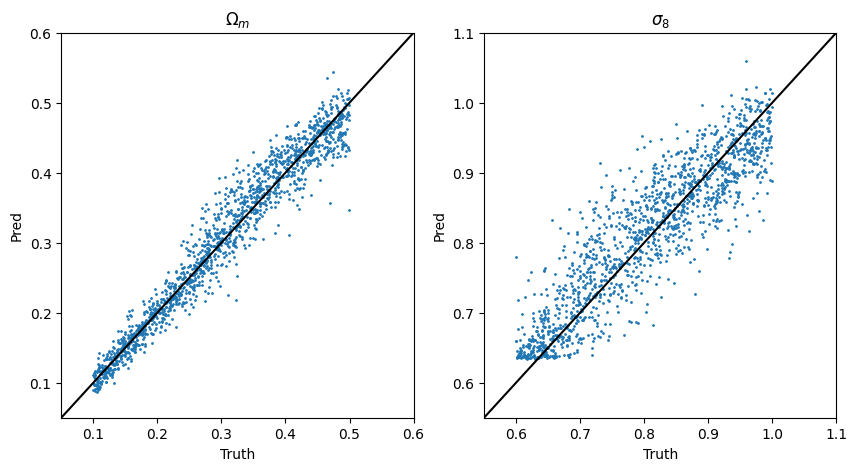

In [72]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("$\Omega_m$")
plt.scatter(trut_cos[:,0], pred_cos[:,0], s=1)
plt.xlim(0.05, 0.6)
plt.ylim(0.05, 0.6)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(122)
plt.title("$\sigma_8$")
plt.scatter(trut_cos[:,1], pred_cos[:,1], s=1)
plt.xlim(0.55, 1.1)
plt.ylim(0.55, 1.1)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

Text(0, 0.5, 'Pred')

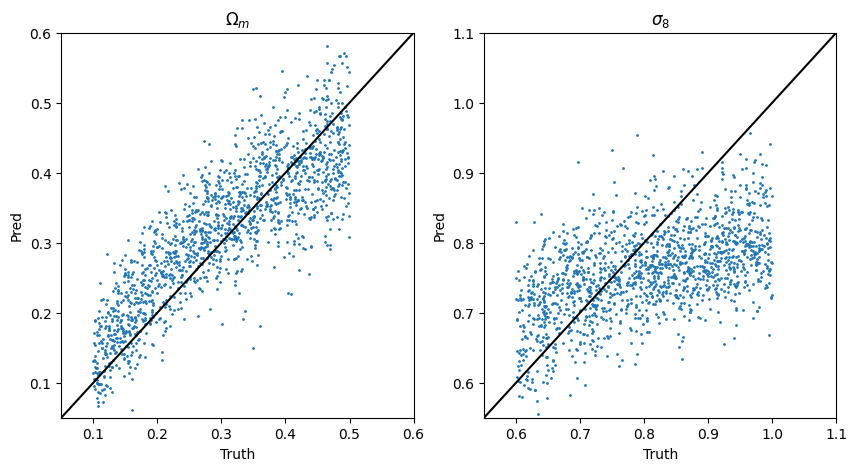

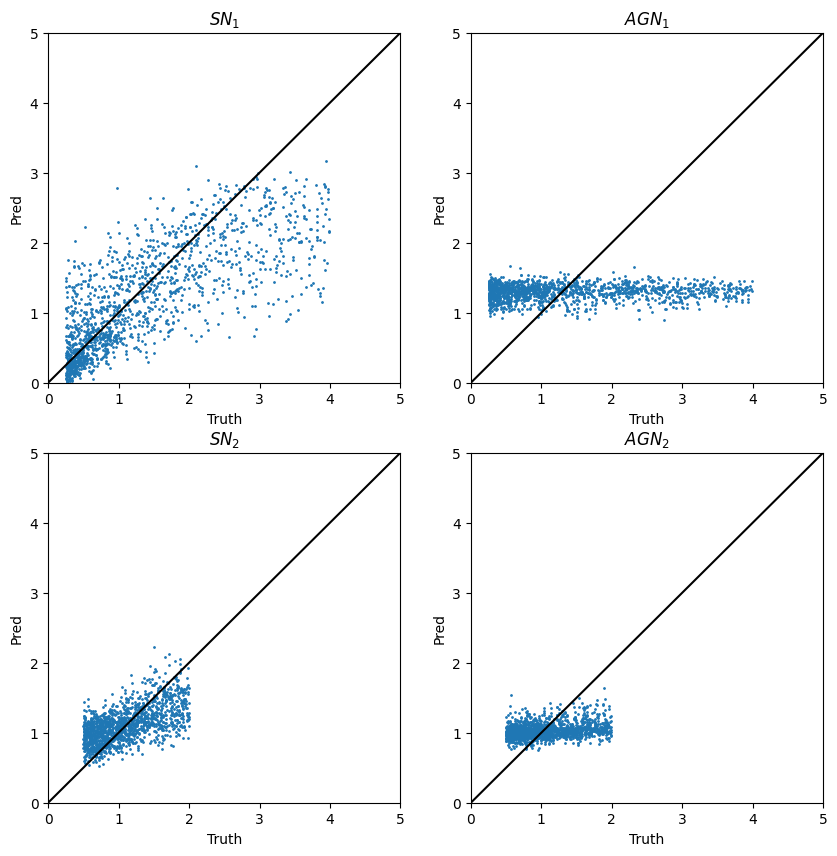

In [90]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("$\Omega_m$")
plt.scatter(trut_all[:,0], pred_all[:,0], s=1)
plt.xlim(0.05, 0.6)
plt.ylim(0.05, 0.6)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(122)
plt.title("$\sigma_8$")
plt.scatter(trut_all[:,1], pred_all[:,1], s=1)
plt.xlim(0.55, 1.1)
plt.ylim(0.55, 1.1)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")


plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("$SN_1$")
plt.scatter(trut_all[:,2], pred_all[:,2], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(222)
plt.title("$AGN_1$")
plt.scatter(trut_all[:,3], pred_all[:,3], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(223)
plt.title("$SN_2$")
plt.scatter(trut_all[:,4], pred_all[:,4], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(224)
plt.title("$AGN_2$")
plt.scatter(trut_all[:,5], pred_all[:,5], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

-----

In [95]:
img_list = np.load("/home/chenze/data_gpfs02/CAMELS_multifield/dataset/compiled_img_SIMBA.npy")
img_list = torch.FloatTensor(img_list)
lab_list = np.load("/home/chenze/data_gpfs02/CAMELS_multifield/dataset/compiled_params_SIMBA.npy")
lab_list = torch.FloatTensor(lab_list)

np.random.seed(rng_seed)
shuffle = np.arange(img_list.shape[0])
np.random.shuffle(shuffle)

img_list = img_list[shuffle]
lab_list = lab_list[shuffle]

len_training = int(len(img_list) * training_ratio)
len_valid = int(len(img_list) * training_ratio) + int(len(img_list) * valid_ratio)

test_set_cos  = CosDataset(img_list[len_valid:], lab_list[len_valid:], tfm=test_tfm, mode="cosmo")
test_loader_cos = DataLoader(test_set_cos, batch_size=1500, shuffle=True, pin_memory=True)

test_set_all  = CosDataset(img_list[len_valid:], lab_list[len_valid:], tfm=test_tfm, mode="all")
test_loader_all = DataLoader(test_set_all, batch_size=1500, shuffle=True, pin_memory=True)

In [96]:
for batch_data, batch_targ in list(test_loader_cos)[0:1]:
    pred_cos = net_cos(batch_data.to(device)).to("cpu").detach().numpy()
    trut_cos = np.array(batch_targ)

In [97]:
for batch_data, batch_targ in list(test_loader_all)[0:1]:
    pred_all = net_all(batch_data.to(device)).to("cpu").detach().numpy()
    trut_all = np.array(batch_targ)

Text(0, 0.5, 'Pred')

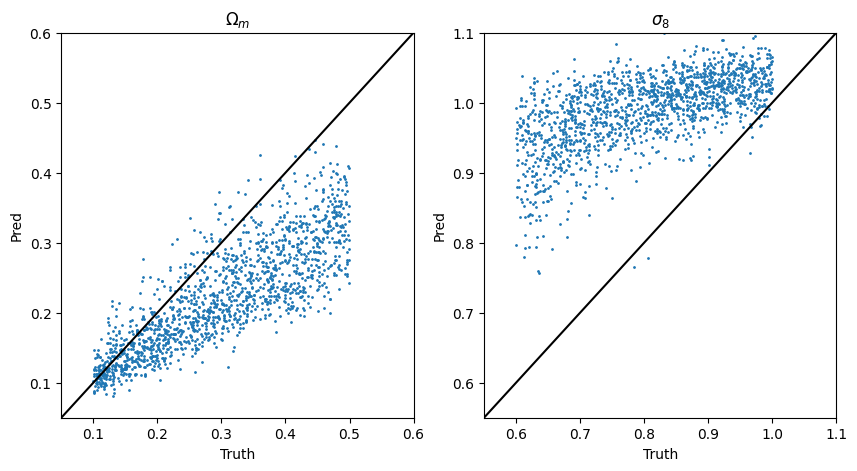

In [99]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("$\Omega_m$")
plt.scatter(trut_cos[:,0], pred_cos[:,0], s=1)
plt.xlim(0.05, 0.6)
plt.ylim(0.05, 0.6)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(122)
plt.title("$\sigma_8$")
plt.scatter(trut_cos[:,1], pred_cos[:,1], s=1)
plt.xlim(0.55, 1.1)
plt.ylim(0.55, 1.1)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

Text(0, 0.5, 'Pred')

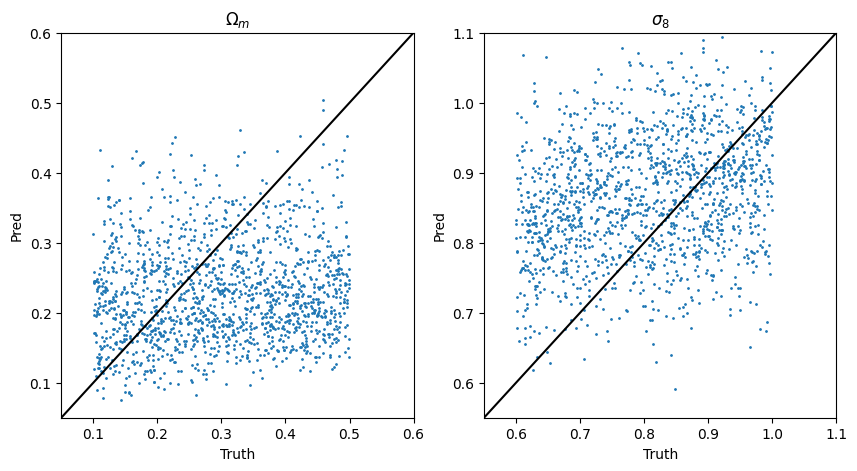

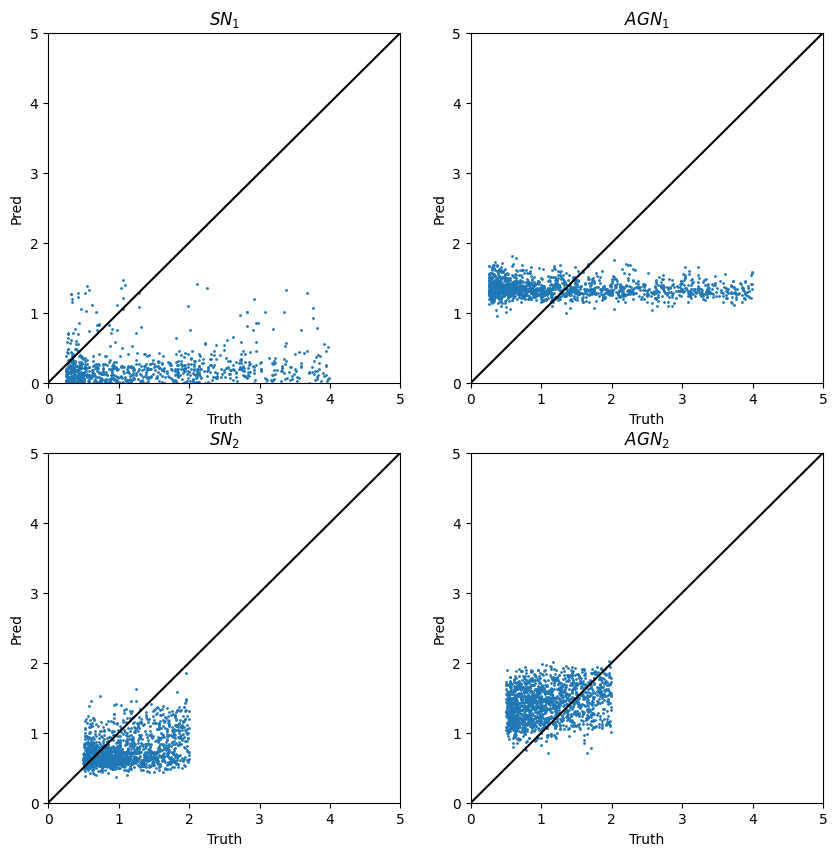

In [98]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("$\Omega_m$")
plt.scatter(trut_all[:,0], pred_all[:,0], s=1)
plt.xlim(0.05, 0.6)
plt.ylim(0.05, 0.6)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(122)
plt.title("$\sigma_8$")
plt.scatter(trut_all[:,1], pred_all[:,1], s=1)
plt.xlim(0.55, 1.1)
plt.ylim(0.55, 1.1)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")


plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("$SN_1$")
plt.scatter(trut_all[:,2], pred_all[:,2], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(222)
plt.title("$AGN_1$")
plt.scatter(trut_all[:,3], pred_all[:,3], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(223)
plt.title("$SN_2$")
plt.scatter(trut_all[:,4], pred_all[:,4], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")

plt.subplot(224)
plt.title("$AGN_2$")
plt.scatter(trut_all[:,5], pred_all[:,5], s=1)
plt.xlim(0., 5.)
plt.ylim(0., 5.)
plt.plot([0, 10], [0, 10], c='black')
plt.xlabel("Truth")
plt.ylabel("Pred")